# 图像语义分割

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchvision import transforms
import torchvision

#### 使用预训练的图像语义分割网络

In [2]:
model = torchvision.models.segmentation.fcn_resnet101(pretrained = True)
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

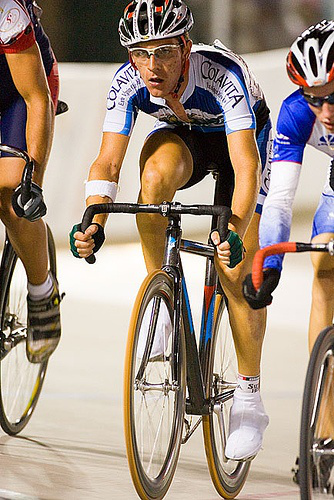

In [3]:
img = PIL.Image.open('D:/迅雷下载/VOCdevkit/VOC2012/JPEGImages/2007_000129.jpg')
img

In [4]:
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
])
image_tensor = img_transforms(img).unsqueeze(0)

In [5]:
image_tensor.shape

torch.Size([1, 3, 500, 334])

In [6]:
output = model(image_tensor)['out']

C:\developer\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
outarg = torch.argmax(output.squeeze(), dim = 0).numpy()
outarg

array([[15, 15, 15, ...,  0,  0,  0],
       [15, 15, 15, ...,  0,  0,  0],
       [15, 15, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [8]:
def decode_segmaps(image, label_color,nc=21):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for cla in range(0, nc):
        idx = image == cla
        r[idx] = label_color[cla,0]
        g[idx] = label_color[cla,1]
        b[idx] = label_color[cla,2]
    rgbimage = np.stack([r,g,b], axis = 2)
    return rgbimage

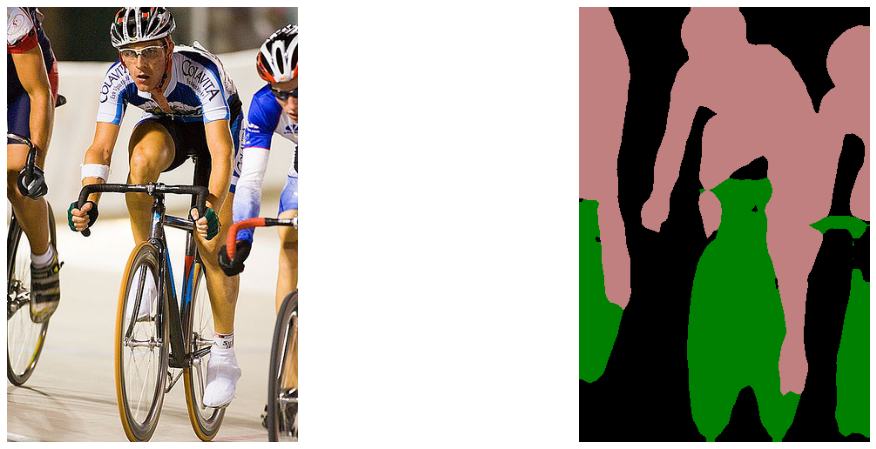

In [9]:
label_colors = np.array([(0,0,0),(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),
                        (64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)])
outputrgb = decode_segmaps(outarg, label_colors)
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(outputrgb)
plt.axis('off')
plt.subplots_adjust(wspace = 0.05)
plt.show()

#### 训练自己的语义分割网络

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from PIL import Image
from time import time
import os
from skimage.io import imread
import copy
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.models import vgg19
from torchsummary import summary

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
classes = ['background', 'aeroplane', 'bicycle', 'bird',' boat','bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
          'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
colormap = [(0,0,0),(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),
                        (64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]

In [13]:
def image2label(image, colormap):
    cm2lbl = np.zeros(256*3)
    for i,cm in enumerate(colormap):
        cm2lbl[(cm[0]*256+cm[1]*256+cm[2])] = i
    image = np.array(image, dtype = "int64")
    ix = (image[:,:,0] * 256 + image[:,:,1] * 256 + image[:,:,2])
    image2 = cm2lbl[ix]
    return image2

In [14]:
def rand_crop(data, label, high, width):
    im_width, im_high = data.size
    left = np.random.randint(0, im_width - width)
    top = np.random.randint(0, im_high - high)
    right = left + width
    bottom = top + high
    data = data.crop((left, top, right, bottom))
    label = label.crop((left, top, right, bottom))
    return data, label

In [15]:
def img_transforms(data, label, high, width, colormap):
    data, label = rand_crop(data, label, high, width)
    data_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    data = data_tfs(data)
    label = torch.from_numpy(image2label(label, colormap))
    return data, label

In [16]:
def read_image_path(root = "D:/迅雷下载/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"):
    image = np.loadtxt(root, dtype = str)
    n = len(image)
    data, label = [None]*n, [None]*n
    for i, fname, in enumerate(image):
        data[i] = "D:/迅雷下载/VOCdevkit/VOC2012/JPEGImages/%s.jpg" % (fname)
        label[i] = 'D:/迅雷下载/VOCdevkit/VOC2012/SegmentationClass/%s.png' % (fname)
    return data, label

In [17]:
class MyDataset(Data.Dataset):
    def __init__(self, data_root, high, width, imtransform, colormap):
        self.data_root = data_root
        self.high = high
        self.width = width
        self.imtransform = imtransform
        self.colormap = colormap
        data_list, label_list = read_image_path(root = data_root)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
    def _filter(self, images):
        return [im for im in images if (Image.open(im).size[1] > high and Image.open(im).size[0] > width)]
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.imtransform(img, label, self.high, self.width, self.colormap)
        return img, label
    def __len__(self):
        return len(self.data_list)

In [18]:
high, width = 320, 480
voc_train = MyDataset('D:/迅雷下载/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt', high, width, img_transforms, colormap)
voc_val =  MyDataset('D:/迅雷下载/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt', high, width, img_transforms, colormap)  
train_loader = Data.DataLoader(voc_train, batch_size = 4, shuffle = True, num_workers = 8, pin_memory = True)
val_loader = Data.DataLoader(voc_val, batch_size = 4, shuffle = True, num_workers = 8, pin_memory = True)

In [ ]:
for step,(data, target) in enumerate(train_loader):
    if step > 0:
        break
    print(data.shape)
    print(target.shape)